# Making a Freind ChatBot Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer

batchsiz = 64
blocksiz = 128
epochs = 600
evalIntervals = 100
lr = 3e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
evaliters = 100
nemb = 112
nhead = 2
nlayers = 2
dropout = 0.1

with open("/kaggle/input/friend-bot/dialogs.txt", 'r', encoding="utf-8") as file:
    txt = file.read()

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B-Instruct")

def enc(txt, tok):
    tokns = tok(txt, return_tensors="pt", truncation=True, padding=False)["input_ids"]
    return tokns.flatten()

data = torch.tensor(enc(txt, tokenizer), dtype=torch.long)

n = int(0.9*len(data))
trainData = data[:n]
valData = data[n:]

vocabsiz = tokenizer.vocab_size
print(f"vocab siz: {vocabsiz}")

def getBatch(split):
    dataset = trainData if split == 'train' else valData
    ix = torch.randint(0, len(dataset) - blocksiz, (batchsiz,))

    x = torch.stack([dataset[i:i+blocksiz] for i in ix])
    y = torch.stack([dataset[i+1:i+blocksiz+1] for i in ix])
    x, y = x.to(device), y.to(device)

    return x, y 
    
def estimateLoss():
    out = { }
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(evaliters)
        for k in range(evaliters):
            x, y = getBatch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    
    model.train()
    return out 

class Head(nn.Module):
    def __init__(self, headsiz):
        super().__init__()
        self.key = nn.Linear(nemb, headsiz, bias=False)
        self.quary = nn.Linear(nemb, headsiz, bias=False)
        self.value = nn.Linear(nemb, headsiz, bias=False)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer("tril", torch.tril(torch.ones(blocksiz, blocksiz)))
    
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.quary(x)

        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        w = w.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        w = F.softmax(w, dim=-1)
        v = self.value(x)
        out = w @ v
         
        return out 

class MultiHeadAttention(nn.Module):
    def __init__(self, nhead, headsiz):
        super().__init__()
        self.heads = nn.ModuleList([Head(headsiz) for _ in range(nhead)])
        self.proj = nn.Linear(headsiz * nhead, nemb)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads])
        out = self.dropout(self.proj(x))
        return out 

class FeedForwadNetwork(nn.Module):
    def __init__(self, nemb):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nemb, 4 * nemb), 
            nn.ReLU(),
            nn.Linear(4 * nemb, nemb),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)
class Block(nn.Module):
    def __init__(self, nemb, nhead):
        super().__init__()
        headsiz = nemb // nhead
        self.self_attn = MultiHeadAttention(nhead, headsiz)
        self.ffn = FeedForwadNetwork(nemb)
        self.ln_1 = nn.LayerNorm(nemb)
        self.ln_2 = nn.LayerNorm(nemb)
    
    def forward(self, x):
        x = x + self.self_attn(self.ln_1(x))
        x = x + self.ffn(self.ln_2(x))
        return x 

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.wte = nn.Embedding(vocabsiz, nemb)
        self.wpe = nn.Embedding(blocksiz, nemb)
        self.block = nn.Sequential(*[Block(nemb, nhead=nhead) for _ in range(nlayers)])
        self.ln_finl = nn.LayerNorm(nemb)
        self.lm_Head = nn.Linear(nemb, vocabsiz)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, ix, targt=None):
        B, T = ix.shape
        tokEmb = self.wte(ix)
        posEmb = self.wpe(torch.arange(T, device=device))

        x = tokEmb + posEmb
        for block in self.block:
            x = block(x)
        x =  self.ln_finl(x)

        logits = self.lm_Head(x)

        if targt is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targt = targt.view(B*T)
            loss = F.cross_entropy(logits, targt)

        return logits, loss 
    
    def genarate(self,ix, maxNewTok, tokenizer):
        # idx is (B, T) array of indices in the current context
        for _ in range(maxNewTok):
            # crop idx to the last block_size tokens
            ixCond = ix[:, -blocksiz:]

            # predict
            logits, loss = self(ixCond)
            
            # focus only on the last time step
            logits = logits[:, -1, :]
            
            probs = F.softmax(logits, dim=-1)

            # sample from the distribution
            ixNxt = torch.multinomial(probs, num_samples=1)

            # append sampled index to the running sequence
            ix = torch.cat((ix, ixNxt), dim=1)

        genTxt = tokenizer.decode(ix[0].cpu().numpy().tolist(), skip_special_tokens=True)
        return genTxt

model = GPTLanguageModel()
m = model.to(device)
# Use Torch.Compinle,, well Expect that fucking Error
useCompile = False
if useCompile:
    model = torch.compile(model)
    print("using Torch Compile")

optim = torch.optim.AdamW(model.parameters(), lr=lr)


lossi = []
for i in range(epochs):
    if i % evalIntervals == 0 or i == epochs - 1:
        losses = estimateLoss()
        lossi.append(losses["val"].item())
        print(f"Step {i} | train loss {losses['train']:.4f} | val loss {losses['val']:.4f}")
    
    Xb, Yb = getBatch("train")
    logits, loss = model(Xb, Yb)

    optim.zero_grad()
    loss.backward()
    optim.step()



import os
def saveCheckpnt(model, optimizer, epoch, loss, filename):
   
    # Construct the full path
    filepath = os.path.join(directory, filename)
    
    # Save the checkpoint
    checkPnt = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkPnt)

# Saving model checkpoint
saveCheckpnt(model, optim, epochs-1, lossi[-1], "TherapyModelTrainFinl.pth")

tokenizer_config.json:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

<ipython-input-3-61b04d863cb3>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(enc(txt, tokenizer), dtype=torch.long)


vocab siz: 49152


KeyboardInterrupt: 

In [4]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)  # Initial context
genTxt = model.genarate(context, maxNewTok=500, tokenizer=tokenizer)

print(genTxt) 


 cold than hot.	you're right.
i really big campus.
any rain in ninety degrees outside, that it was hot.	i enjoy the middle of the summer.	that's okay.
it's nice out?
i really hope it rains.	yes, it started rained and i wish it rains.	considering that it rains.	yes, but i hope it does rain clears the winter, so fresh after it wouldn't seem right if it there are a lot of summer, but it raining in the sky looks so far?	i feel.	i enjoy the winter.	that would be weird.	exactly, it rains.	never better, but i hope that it wasn't rain.	it's an ugly day?	so how about you go to rain.	i know what you like it started rained and i'd rather be pointless.
it rains.  
considering that it may rain later.
in the winter too.	how come soon. what you mean, it rains.	i like it smells so hot.
do you?	no problem. i hope it's the night air.	it wouldn't seem right now.	yeah, but i feel. 
i want winter, but i think it was a lot of summer.
it really would be pointless. what about you. it to cool off one day.
i'm 

# Ploting The loss Curve of Overfit Model

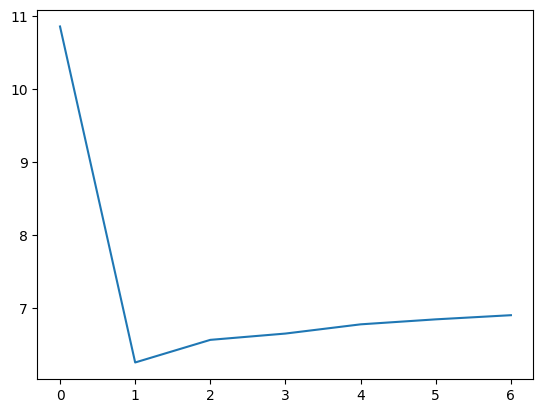

In [5]:

import matplotlib.pyplot as plt

plt.plot(lossi)

# Since The Model is Overfit,
# gonna Retrain the Model with Adjust Prarameters 


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer
#from transformers import GPT2Tokenizer



batchsiz = 64
blocksiz = 128
epochs = 600
evalIntervals = 200
lr = 3e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
evaliters = 50
nemb = 112
nhead = 2
nlayers = 1
dropout = 0.3

with open("/kaggle/input/friend-bot/dialogs.txt", 'r', encoding="utf-8") as file:
    txt = file.read()

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B-Instruct")

def enc(txt, tok):
    tokns = tok(txt, return_tensors="pt", truncation=True, padding=False)["input_ids"]
    return tokns.flatten()

data = torch.tensor(enc(txt, tokenizer), dtype=torch.long)

n = int(0.9*len(data))
trainData = data[:n]
valData = data[n:]

vocabsiz = tokenizer.vocab_size
print(f"vocab siz: {vocabsiz}")

def getBatch(split):
    dataset = trainData if split == 'train' else valData
    ix = torch.randint(0, len(dataset) - blocksiz, (batchsiz,))

    x = torch.stack([dataset[i:i+blocksiz] for i in ix])
    y = torch.stack([dataset[i+1:i+blocksiz+1] for i in ix])
    x, y = x.to(device), y.to(device)

    return x, y 

def estimateLoss():
    out = { }
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(evaliters)
        for k in range(evaliters):
            x, y = getBatch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    
    model.train()
    return out 

class Head(nn.Module):
    def __init__(self, headsiz):
        super().__init__()
        self.key = nn.Linear(nemb, headsiz, bias=False)
        self.quary = nn.Linear(nemb, headsiz, bias=False)
        self.value = nn.Linear(nemb, headsiz, bias=False)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer("tril", torch.tril(torch.ones(blocksiz, blocksiz)))
    
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.quary(x)

        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        w = w.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        w = F.softmax(w, dim=-1)
        v = self.value(x)
        out = w @ v
         
        return out 

class MultiHeadAttention(nn.Module):
    def __init__(self, nhead, headsiz):
        super().__init__()
        self.heads = nn.ModuleList([Head(headsiz) for _ in range(nhead)])
        self.proj = nn.Linear(headsiz * nhead, nemb)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads])
        out = self.dropout(self.proj(x))
        return out 

class FeedForwadNetwork(nn.Module):
    def __init__(self, nemb):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nemb, 4 * nemb), 
            nn.ReLU(),
            nn.Linear(4 * nemb, nemb),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, nemb, nhead):
        super().__init__()
        headsiz = nemb // nhead
        self.self_attn = MultiHeadAttention(nhead, headsiz)
        self.ffn = FeedForwadNetwork(nemb)
        self.ln_1 = nn.LayerNorm(nemb)
        self.ln_2 = nn.LayerNorm(nemb)
    
    def forward(self, x):
        x = x + self.self_attn(self.ln_1(x))
        x = x + self.ffn(self.ln_2(x))
        return x 

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.wte = nn.Embedding(vocabsiz, nemb)
        self.wpe = nn.Embedding(blocksiz, nemb)
        self.block = nn.Sequential(*[Block(nemb, nhead=nhead) for _ in range(nlayers)])
        self.ln_finl = nn.LayerNorm(nemb)
        self.lm_Head = nn.Linear(nemb, vocabsiz)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, ix, targt=None):
        B, T = ix.shape
        tokEmb = self.wte(ix)
        posEmb = self.wpe(torch.arange(T, device=device))

        x = tokEmb + posEmb
        for block in self.block:
            x = block(x)
        x =  self.ln_finl(x)

        logits = self.lm_Head(x)

        if targt is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targt = targt.view(B*T)
            loss = F.cross_entropy(logits, targt, label_smoothing=0.1)

        return logits, loss 
    
    def genarate(self,ix, maxNewTok, tokenizer):
        # idx is (B, T) array of indices in the current context
        for _ in range(maxNewTok):
            # crop idx to the last block_size tokens
            ixCond = ix[:, -blocksiz:]

            # predict
            logits, loss = self(ixCond)
            
            # focus only on the last time step
            logits = logits[:, -1, :]
            
            probs = F.softmax(logits, dim=-1)

            # sample from the distribution
            ixNxt = torch.multinomial(probs, num_samples=1)

            # append sampled index to the running sequence
            ix = torch.cat((ix, ixNxt), dim=1)

        genTxt = tokenizer.decode(ix[0].cpu().numpy().tolist(), skip_special_tokens=True)
        return genTxt

model = GPTLanguageModel()
m = model.to(device)
# Use Torch.Compinle,, well Expect that fucking Error
useCompile = False
if useCompile:
    model = torch.compile(model)
    print("using Torch Compile")
else:
    print("Not using Torch Compile")


optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01) #add weight decay to avoid overfit
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=10, verbose=True) 
trainLoss = []
valLoss = []
for i in range(epochs):
    if i % evalIntervals == 0 or i == epochs - 1:
        losses = estimateLoss()
        trainLoss.append(losses["train"].item())
        valLoss.append(losses["val"].item())
        print(f"Step {i+1} | train loss {losses['train']:.4f} | val loass {losses['val']:.4f}")
    
    xb, yb = getBatch("train")
    logits, loss = model(xb, yb)

    optim.zero_grad()
    loss.backward()
    optim.step()

def saveCheckpnt(model, optimizer, epoch, loss, filepath):
    checkPnt = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkPnt, filepath)
    print(f"Checkpoint saved to {filepath}")

# Saving model checkpoint
saveCheckpnt(model, optim, epochs-1, valLoss[-1], "FreindBotModelTrainFinl.pth")

vocab siz: 49152
Not using Torch Compile


<ipython-input-5-466cd81d127f>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(enc(txt, tokenizer), dtype=torch.long)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 14.74 GiB of which 730.12 MiB is free. Process 2189 has 14.03 GiB memory in use. Of the allocated memory 12.60 GiB is allocated by PyTorch, and 1.30 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)